# Analysis of dynamics by Markov modelling 

Structure based analysis of timescales were done using a Markov modelling approach. Individual residue backbone dihedral angles were used due to their direct relation to protein secondary strucutre. Here we focus on helix 1 residue (18-26). Analysis include the following steps:

1) read in dihedral data of selected residues
2) TICA trasformation for dimension reduction
3) Discretization with KMeans clustering
4) Build Markov model
5) Calculate free energy levels from population and estimate mean first passage times between states

In a separate analysis 4 residue segments along the full p53-TAD protein was done. 4 residues are a minimal structural unit to form an $\alpha$-helical turn. The obtained markov model allow to asses the spectrum of time scales within these segments. 


Import packages

In [2]:
import numpy as np
import pandas as pd
from tabulate import tabulate
from tqdm.notebook import tqdm
import re
import matplotlib.pyplot as plt

#trajectory input 
import pyemma

#markov model related functions
from deeptime.markov import TransitionCountEstimator
from deeptime.markov.msm import BayesianMSM 
import deeptime.markov.hmm as hmm
from deeptime.markov.tools.analysis import eigenvectors,eigenvalues,mfpt
from deeptime.markov import pcca
from deeptime.clustering import KMeans
from deeptime.decomposition import TICA

#used constants
from scipy.constants import Avogadro as Av
from scipy.constants import Boltzmann as kB

#free energy unit
kBT = kB*Av*298*1e-3 # kJ/mol

# Define input files and features 

$\Phi$ and $\Psi$ angles of residues 18-26 in a cosine and sine traformation to account for jumps in the angle near 2 $\pi$ rad.

In [3]:
#input files
topology =  "../sample_data/topology.pdb"
trajectory =  "../sample_data/sample_traj.xtc"

#time resolution
stride = 10 #every 10th frame
dt = 1e-9 #time step between these frames, 1 ns

#Features
#initialize
feat = pyemma.coordinates.featurizer(topology)
#add dihedral angles of selected residues in a cosine, sine trasformation
#every residue is decribed by 4 features cosine phi, sine phi, cosine psi, sine psi
feat.add_backbone_torsions(selstr=f'residue {18} to {26}', deg=False, cossin=True, periodic=True)

#residues - based on the selection
resi = np.array([int(re.split('[ )]', s)[3]) for s in feat.describe()])
feature_type = ['COS_PHI', 'SIN_PHI', 'COS_PSI', 'SIN_PSI']*len(resi)

print(resi)

[18 18 18 18 19 19 19 19 20 20 20 20 21 21 21 21 22 22 22 22 23 23 23 23
 24 24 24 24 25 25 25 25 26 26 26 26]


# read in feature data

In [4]:
data = pyemma.coordinates.load(trajectory, features=feat,stride=stride) 
print(data.shape)


(1001, 36)


## create artificial ideal strutures ($\alpha$-helix and $\beta$-sheet) to interpret TICA decomposition

Dihedral angles of ideal secondary sturctures are used to help interpret the TICA decomposition. Namely, after fitting the TICA estimator, these artificial strucutres are also tranformed to see where helix-like and straight peptides land on the TICA map.


In [5]:
#values for a single residue
ideal_alpha = np.array([np.cos(np.deg2rad(-57.8)),np.sin(np.deg2rad(-57.8)),np.cos(np.deg2rad(-47.0)),np.sin(np.deg2rad(-47.0))])
ideal_beta = np.array([np.cos(np.deg2rad(-139.0)),np.sin(np.deg2rad(-139.0)),np.cos(np.deg2rad(135.0)),np.sin(np.deg2rad(135.0))])

#for the same length as the tested protein stretch
ideal_alpha_block = np.tile(ideal_alpha,len(resi)//4).reshape(1,len(resi))
ideal_beta_block = np.tile(ideal_beta,len(resi)//4).reshape(1,len(resi))

# fit TICA transformer and project data

In [6]:
#TiCa model fitted on data
lagtime = 10 # 10 ns

tica = TICA(lagtime=lagtime) # 
tica.fit(data)
tica_model = tica.fetch_model()
tica_projection = tica.transform(data)
tica_projection_helix = tica.transform(ideal_alpha_block).ravel()
tica_projection_beta = tica.transform(ideal_beta_block).ravel()
print(tica_projection.shape)

(1001, 36)


## plot TICA decomposition

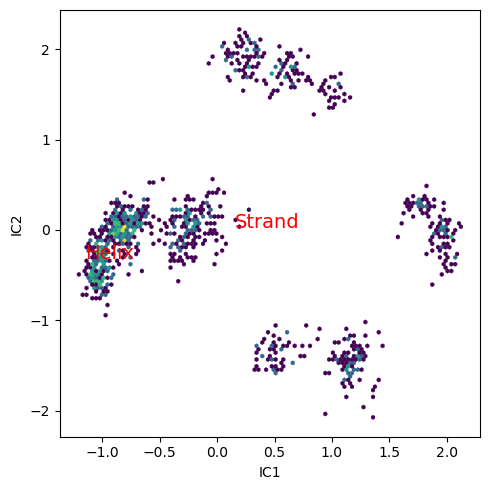

In [7]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)

ax.hexbin(tica_projection[:,0],tica_projection[:,1],bins='log',linewidths=0.2)
ax.text(tica_projection_helix[0],tica_projection_helix[1],"Helix",color='red',size=14)
ax.text(tica_projection_beta[0],tica_projection_beta[1],"Strand",color='red',size=14)
ax.set_xlabel("IC1")
ax.set_ylabel("IC2")
plt.tight_layout()

## use only TICA ICs which have at least a 100 ns time scale 

In [8]:
# which timescales are above 100 ns
TICA_IC_mask = tica_model.timescales(lagtime=lagtime) > 100 # 100 ns
print(tica_model.timescales(lagtime=lagtime))

[403.1652018  140.53395757  88.92753129  62.85498684  41.56125219
  32.72945386  26.41386196  23.5249206   18.11402588  14.8946816
  12.26256259  12.09716309   7.49243314   6.97867119   6.56966692
   6.38083941   5.87781649   5.70689618   5.27578119   5.14041209
   5.11075783   4.92393495   4.83995133   4.78899962   4.53353313
   4.19364736   3.93889889   3.7254657    3.67204439   3.63378616
   3.55169555   2.65808103   2.63109482   2.38510032   2.37756755
   1.73685194]


# KMeans clustering for micro state assignement

In [9]:
#Kmeans for centroid determination and assignment

n_cluster = 15 # for the full data set it is 150
KMeans_estimator = KMeans(
            n_clusters = n_cluster,  
            init_strategy='kmeans++', 
            max_iter=500,  
            fixed_seed=13,
            n_jobs=4)

#estimate
clustering = KMeans_estimator.fit(tica_projection[:,TICA_IC_mask]).fetch_model()
#get centroids
centroids = clustering.cluster_centers # rows the centroids, cols the IC dimensions
#get micro state assignment
assignment = clustering.transform(tica_projection[:,TICA_IC_mask])


## check clustering

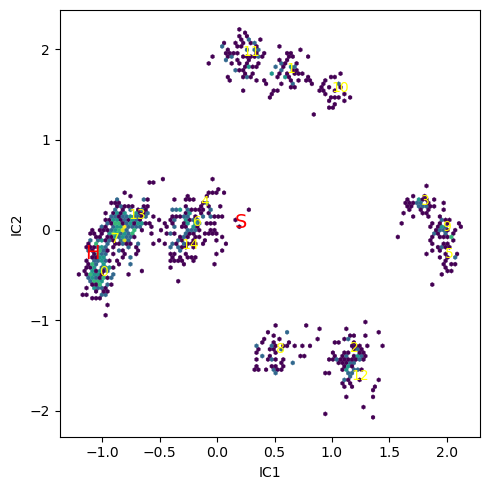

In [10]:
#lets have a look 

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)

ax.hexbin(tica_projection[:,0],tica_projection[:,1],bins='log',linewidths=0.2)
ax.text(tica_projection_helix[0],tica_projection_helix[1],"H",color='red',size=14)
ax.text(tica_projection_beta[0],tica_projection_beta[1],"S",color='red',size=14)
#plot centroids
[ax.text(centroids[i,0],centroids[i,1],str(i),color="yellow") for i in range(n_cluster)]

ax.set_xlabel("IC1")
ax.set_ylabel("IC2")

plt.tight_layout()


# Hidden Markov Model with different number of macro states

The macro states are determined by a hidden markov model based on the micro states of the KMeans clustering

In [11]:
#we test multiple possibilities 
n_hidden_states = np.array([5,7,9])

#lists to contain hidden markov models and related estimates
HMM_posteriors = []
HMM_timescales = []
Tmats = [] # transition matrices
out_probs = [] # probablity matrix of macro state for micro states

for i,n in enumerate(tqdm(n_hidden_states)):
    #Initialize estimator
    HMM_estimator = hmm.BayesianHMM.default(assignment, n_hidden_states=n, lagtime=lagtime)
    #fit to data
    HMM_posterior = HMM_estimator.fit(assignment,
                                            n_samples = 100,
                                            stride = 'effective',
                                            n_burn_in=100,  # number of sampling steps to discard at the beginning
                                            n_thin=1 ).fetch_model()
    #posterior macro states
    HMM_posteriors.append(HMM_posterior)
    #get trasition matrices with confidence
    Tmats.append( HMM_posterior.gather_stats("transition_model/transition_matrix", confidence=0.95))
    #time scales
    HMM_timescales.append(HMM_posterior.gather_stats("timescales", confidence=0.95))
    #probabilities
    out_probs.append( HMM_posterior.gather_stats("output_probabilities", confidence=0.95).mean)


  0%|          | 0/3 [00:00<?, ?it/s]

## time scales of macro states

  0%|          | 0/3 [00:00<?, ?it/s]

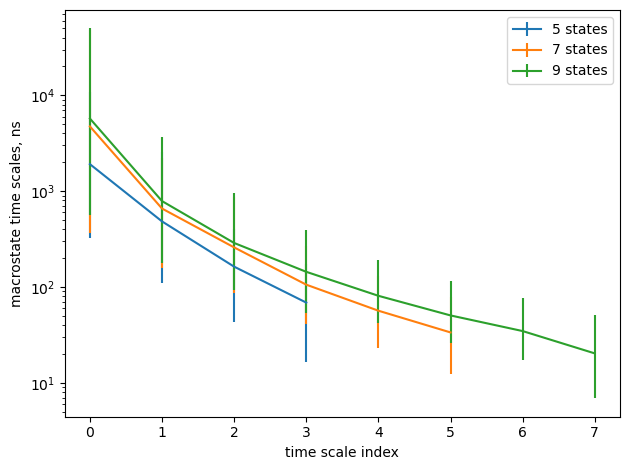

In [12]:
for i,n in enumerate(tqdm(n_hidden_states)):
    t_scales = HMM_timescales[i]
    plt.errorbar(np.arange(n-1),t_scales.mean,yerr=np.row_stack([t_scales.mean-t_scales.L,t_scales.R-t_scales.mean]) ,
                 label=f"{n} states")

plt.ylabel("macrostate time scales, ns")
plt.xlabel("time scale index")
plt.yscale("log")
plt.legend()
plt.tight_layout()

# structures of representative states

Using the histogram we determine the higest density (lowest free energy) location and the trajectory timepoint closest to it, thereby getting a representative strucutre for that macro state.


In [13]:
#data to be used
tica_subset = tica_projection[:, np.where(TICA_IC_mask)[0]]

#frame index
original_index = np.arange(tica_projection.shape[0])

#list of macro state free energy minima locations
macrostate_minima_list = []
#list of frame indexes for the free energy minimas
minima_frames_list = []

for j,n in enumerate(tqdm(n_hidden_states)):
    #get macro state assignment fo every frame
    out_prob = out_probs[j]
    coarse_state = np.argmax(out_prob[:,assignment],axis=0)

    #temporary storage for a given macro state count
    macrostate_minima = []
    minima_frames = []

    for i in range(n):
        frames = tica_subset[coarse_state == i , :]
        index_subset = original_index[coarse_state == i]

        #create a histogram to determine minima
        H, edges = np.histogramdd(frames,bins=np.floor(np.sqrt(tica_subset.shape[0])).astype(int)) # for the full data set 200 bins were used
        max_ind = np.unravel_index(np.argmax(H), H.shape, order='C') # highest populated bin
        temp = []
        for k,edge in enumerate(edges):
            centr = (edge[1:]+edge[:-1])/2
            temp.append(centr[max_ind[k]])
        macrostate_minima.append(np.array(temp)) # this is a location
        #get frame in the minimal bin
        minima_frames.append(index_subset[np.argmin(np.sum((frames - np.array(temp))**2,axis=1))])

    macrostate_minima_list.append(macrostate_minima)
    minima_frames_list.append(minima_frames)

    

  0%|          | 0/3 [00:00<?, ?it/s]

In [23]:
coarse_state

array([5, 5, 5, ..., 5, 5, 5])

## Plot - trace back macrostates to frames

  0%|          | 0/3 [00:00<?, ?it/s]

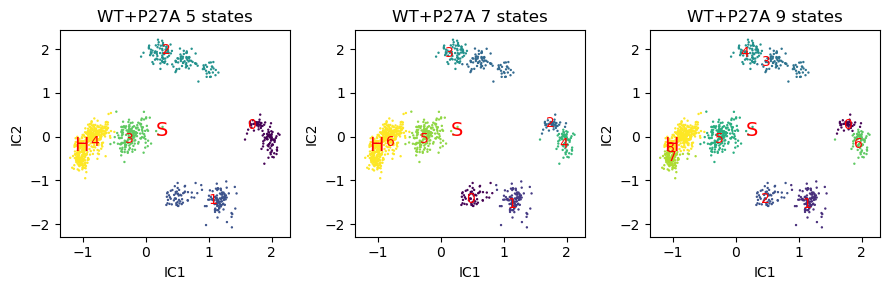

In [15]:
RANGE = np.arange(0,tica_projection.shape[0],1) # show every point

fig = plt.figure(figsize=(3*3,3))
axes = []

for j,n in enumerate(tqdm(n_hidden_states)):
    out_prob = out_probs[j]
    coarse_state = np.argmax(out_prob[:,assignment],axis=0)
    minima_frames = minima_frames_list[j]
    axes.append(fig.add_subplot(1,3,j+1))

    axes[-1].scatter(tica_projection[RANGE,0],
                tica_projection[RANGE,1],
                c = coarse_state[RANGE],
                s=2,marker='.')

    [axes[-1].text(tica_projection[fr,0],tica_projection[fr,1],str(i),color='red',ha='center',va='center')   for i,fr in enumerate(minima_frames)]
    axes[-1].set_title(f"{n} states")
    axes[-1].set_xlabel("IC1") ; axes[-1].set_ylabel("IC2") 

    axes[-1].text(tica_projection_helix[0],tica_projection_helix[1],"H",color='red',size=14)
    axes[-1].text(tica_projection_beta[0],tica_projection_beta[1],"S",color='red',size=14)

plt.tight_layout()

# Let's take the 5 state model


## determine the free energy of the macro states by counting

In [30]:
# assign variables of the 5 state model
out_prob = out_probs[0]
coarse_state = np.argmax(out_prob[:,assignment],axis=0)

#count states, histogram bins are arranged to cut states e.g. edges are  -0.5 - 0.5; 0.5 - 1.5
state_count, _ = np.histogram(coarse_state,bins = np.linspace(-0.5,4.5,6))
#convert to free energy, kBT
FE = -np.log([s/tica_projection.shape[0] for s in state_count])

print(FE)

[2.24531569 1.89147494 1.88487426 1.77885606 0.8613826 ]


## transition times are calculated as the mean first passage time, MFPT, given in ns

Text(0, 0.5, 'origin state')

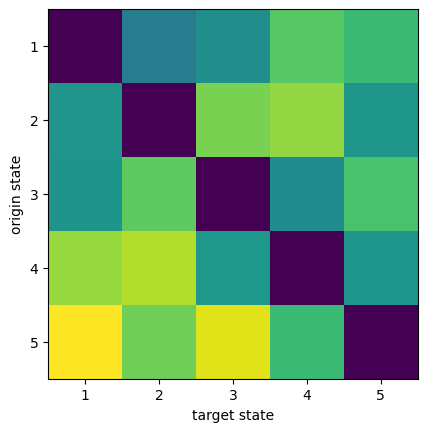

In [33]:
MFPT_mat = np.zeros((5,5))
MFPT_matL = np.zeros((5,5))
MFPT_matR = np.zeros((5,5))
Tmat = HMM_posteriors[0].gather_stats("transition_model/transition_matrix", confidence=0.95).mean
TmatL = HMM_posteriors[0].gather_stats("transition_model/transition_matrix", confidence=0.95).L
TmatR = HMM_posteriors[0].gather_stats("transition_model/transition_matrix", confidence=0.95).R

#a dictionary to rename and merge states
state_dict = {0 : 0, 1 : 1 , 2 : 2, 3 : 3, 4 : 4}

for i in range(5):
    for j in range(5):
        MFPT_mat[j,i] = mfpt(Tmat,target=state_dict[i], origin=state_dict[j], tau=10)

        #scale left and right to row stochastic
        MFPT_matL[j,i] = mfpt(TmatL / np.tile(TmatL.sum(axis=1).reshape(-1,1) ,TmatL.shape[1]),target=state_dict[i], origin=state_dict[j], tau=10)
        MFPT_matR[j,i] = mfpt(TmatR / np.tile(TmatR.sum(axis=1).reshape(-1,1) ,TmatR.shape[1]),target=state_dict[i], origin=state_dict[j], tau=10)
        

plt.imshow(MFPT_mat)
plt.xticks(np.arange(5),np.arange(5)+1)
plt.yticks(np.arange(5),np.arange(5)+1)
plt.xlabel('target state')
plt.ylabel('origin state')


# error estmate of MFPT

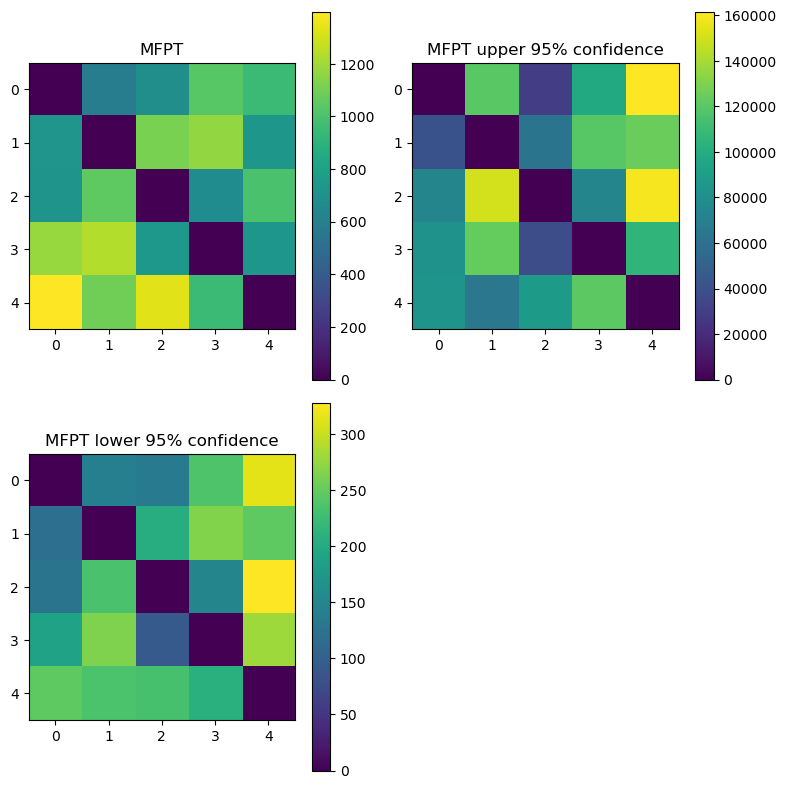

In [35]:

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)

im1 = ax1.imshow(MFPT_mat)
im2 = ax2.imshow(MFPT_matL)
im3 = ax3.imshow(MFPT_matR)

ax1.set_title("MFPT")
ax2.set_title("MFPT upper 95% confidence")
ax3.set_title("MFPT lower 95% confidence")

plt.colorbar(im1,ax=ax1)
plt.colorbar(im2,ax=ax2)
plt.colorbar(im3,ax=ax3)


plt.tight_layout()

In [ ]:
## MFPT table

In [36]:
#print MFPT table un us
from tabulate import tabulate

print(tabulate(np.column_stack([np.arange(5)+1,MFPT_mat*1e-3]), headers=np.arange(5)+1, tablefmt='fancy_grid',floatfmt=".2f"))

╒══════╤══════╤══════╤══════╤══════╤══════╕
│      │    1 │    2 │    3 │    4 │    5 │
╞══════╪══════╪══════╪══════╪══════╪══════╡
│ 1.00 │ 0.00 │ 0.58 │ 0.69 │ 1.04 │ 0.95 │
├──────┼──────┼──────┼──────┼──────┼──────┤
│ 2.00 │ 0.73 │ 0.00 │ 1.12 │ 1.17 │ 0.74 │
├──────┼──────┼──────┼──────┼──────┼──────┤
│ 3.00 │ 0.72 │ 1.05 │ 0.00 │ 0.68 │ 0.99 │
├──────┼──────┼──────┼──────┼──────┼──────┤
│ 4.00 │ 1.18 │ 1.23 │ 0.75 │ 0.00 │ 0.73 │
├──────┼──────┼──────┼──────┼──────┼──────┤
│ 5.00 │ 1.40 │ 1.09 │ 1.33 │ 0.95 │ 0.00 │
╘══════╧══════╧══════╧══════╧══════╧══════╛
